# FogNET

In [57]:
import numpy as np
import os
from pathlib import Path
import zipfile
import torch
import seaborn as sns
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2
import torch.nn as nn
import timm
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

In [58]:
path_fog = './dataaets/dataset_fog'
data = myDataset(root_dir=path_fog)
len(data)

3353

In [59]:
class myDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.im_paths = [im_path for im_path in sorted(glob(f"{root_dir}/*/*.jpg"))]
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1


                
    def get_class(self, path): return os.path.basename(os.path.dirname(path))
    
    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transform is not None:
            im = self.transform(im)
        return im, gt
        
def get_dls(root,batch_size, transforms,  split=[0.8, 0.06, 0.1], ns=4):

    data = myDataset(root_dir=root, transform=transform)
    total_len = len(data)
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (train_len + val_len)

    train_set, val_set, test_set = random_split(dataset=data, lengths=[train_len, val_len, test_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = ns)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers = ns)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers = ns)

    return train_loader, val_loader, test_loader, data.cls_names


In [66]:
mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [67]:
tr_dl, val_dl, test_dl, classes = get_dls(root=path_fog, batch_size=16, transforms=transform)
print(len(tr_dl)); print(len(val_dl)); print(len(test_dl)); print(classes)


168
13
30
{'fog': 0, 'notfog': 1}


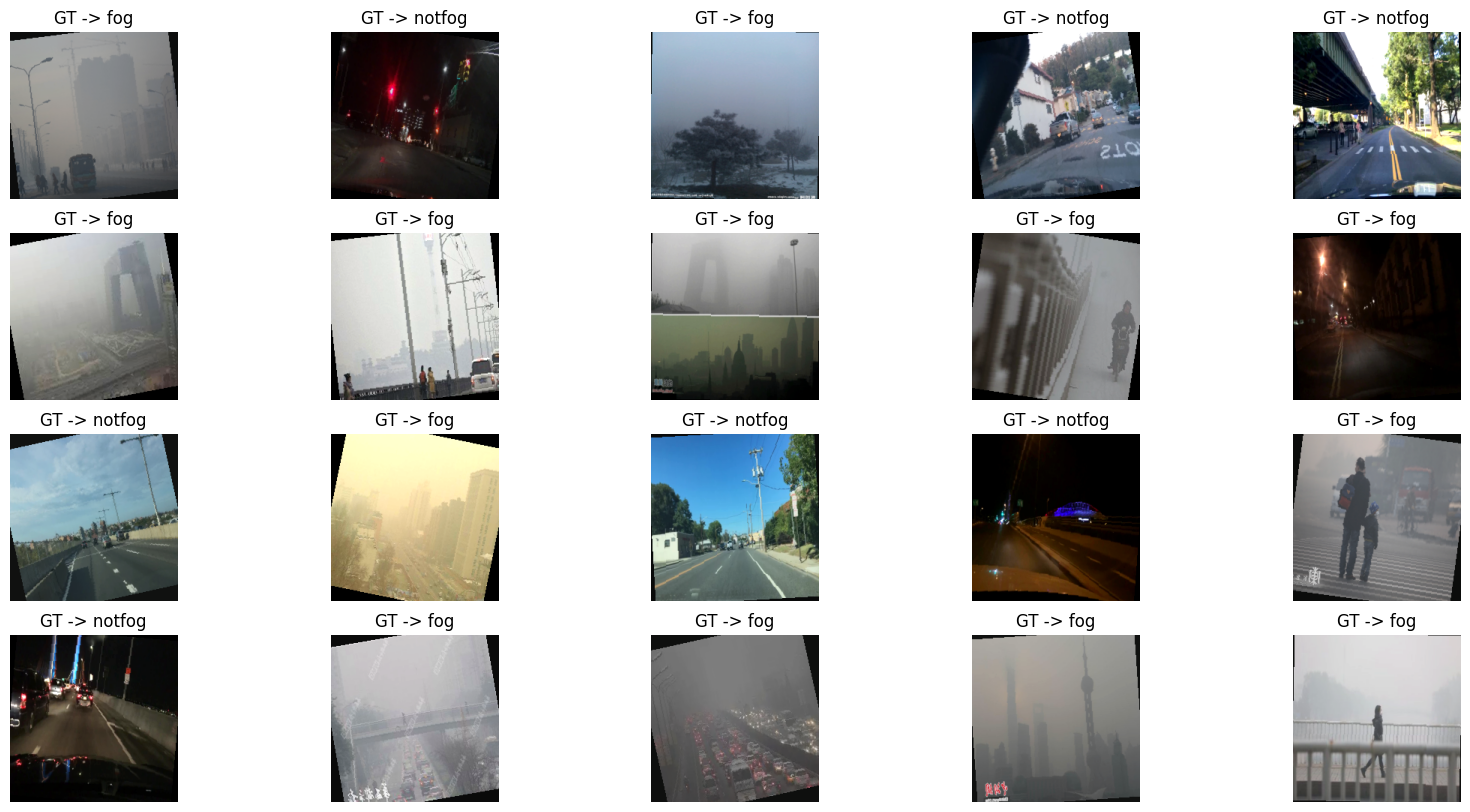

In [79]:
def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = transforms.Compose([transforms.Normalize(mean = [ 0.], std = [1/0.5]), transforms.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

### Создание модели и обучение

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [69]:
m = timm.create_model("cspresnext50", pretrained = False, num_classes = len(classes), drop_rate=0.2)
m = m.to(device)

In [70]:
lr = 0.001
num_epochs = 100

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=m.parameters(), lr = lr, weight_decay=1e-5, betas=(0.9, 0.999))
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []


In [71]:


save_prefix, save_dir = "fog", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5

for epoch in range(num_epochs):
    
    m.train()
    epoch_loss, epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(tr_dl)):
    
        ims = batch[0].to(device)
        gts = batch[1].to(device)
        pred = m(ims)
        loss = loss_fn(pred, gts)
        
        epoch_loss += loss.item()
        epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        
    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)
    
    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for i, batch in tqdm(enumerate(val_dl)):
            ims = batch[0].to(device)
            gts = batch[1].to(device)
            pred = m(ims)
            loss = loss_fn(pred, gts)

            pred_cls = torch.argmax(pred.data, dim = 1)
            val_epoch_loss += loss.item()
            val_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
            
        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
    

Start training...


168it [00:43,  3.86it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.257
1-epoch train accuracy      -> 0.906



13it [00:01,  7.98it/s]


1-epoch validation process is completed!
1-epoch validation loss     -> 0.192
1-epoch validation accuracy -> 0.935


168it [00:42,  3.96it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.208
2-epoch train accuracy      -> 0.931



13it [00:01,  9.32it/s]


2-epoch validation process is completed!
2-epoch validation loss     -> 0.155
2-epoch validation accuracy -> 0.945


168it [00:34,  4.86it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.198
3-epoch train accuracy      -> 0.935



13it [00:01,  8.96it/s]


3-epoch validation process is completed!
3-epoch validation loss     -> 0.169
3-epoch validation accuracy -> 0.920
Loss value did not decrease for 1 epochs


168it [00:31,  5.27it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.169
4-epoch train accuracy      -> 0.945



13it [00:01,  9.32it/s]


4-epoch validation process is completed!
4-epoch validation loss     -> 0.162
4-epoch validation accuracy -> 0.945


168it [00:31,  5.35it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.173
5-epoch train accuracy      -> 0.942



13it [00:01, 11.44it/s]


5-epoch validation process is completed!
5-epoch validation loss     -> 0.160
5-epoch validation accuracy -> 0.940


168it [00:31,  5.40it/s]


6-epoch train process is completed!
6-epoch train loss          -> 0.170
6-epoch train accuracy      -> 0.941


13it [00:01, 11.15it/s]

6-epoch validation process is completed!
6-epoch validation loss     -> 0.215
6-epoch validation accuracy -> 0.950
Loss value did not decrease for 2 epochs



168it [00:30,  5.44it/s]


7-epoch train process is completed!
7-epoch train loss          -> 0.170
7-epoch train accuracy      -> 0.944


13it [00:01, 11.81it/s]


7-epoch validation process is completed!
7-epoch validation loss     -> 0.152
7-epoch validation accuracy -> 0.950


168it [00:31,  5.37it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.160
8-epoch train accuracy      -> 0.948



13it [00:01, 11.27it/s]

8-epoch validation process is completed!
8-epoch validation loss     -> 0.170
8-epoch validation accuracy -> 0.935
Loss value did not decrease for 3 epochs



168it [00:32,  5.18it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.160
9-epoch train accuracy      -> 0.950



13it [00:01,  8.17it/s]


9-epoch validation process is completed!
9-epoch validation loss     -> 0.150
9-epoch validation accuracy -> 0.945


168it [00:32,  5.14it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.154
10-epoch train accuracy      -> 0.951



13it [00:01,  8.75it/s]


10-epoch validation process is completed!
10-epoch validation loss     -> 0.153
10-epoch validation accuracy -> 0.945


168it [00:32,  5.10it/s]

11-epoch train process is completed!
11-epoch train loss          -> 0.161
11-epoch train accuracy      -> 0.949



13it [00:01, 10.43it/s]

11-epoch validation process is completed!
11-epoch validation loss     -> 0.246
11-epoch validation accuracy -> 0.935
Loss value did not decrease for 4 epochs



168it [00:32,  5.22it/s]

12-epoch train process is completed!
12-epoch train loss          -> 0.181
12-epoch train accuracy      -> 0.943



13it [00:01,  9.37it/s]

12-epoch validation process is completed!
12-epoch validation loss     -> 0.171
12-epoch validation accuracy -> 0.945
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


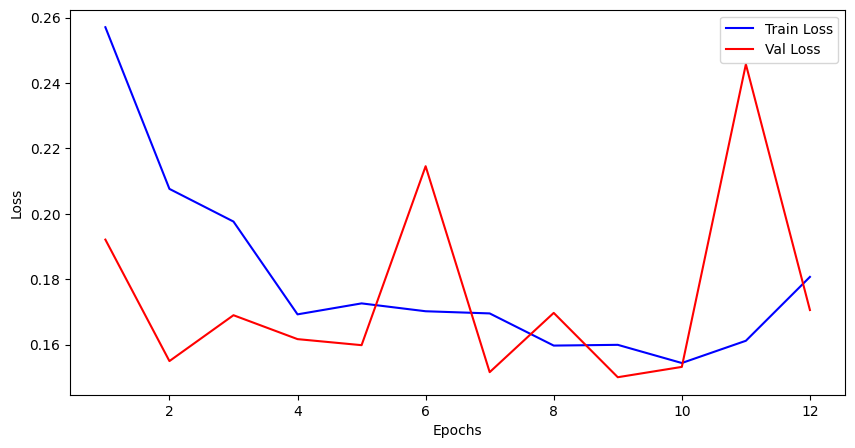

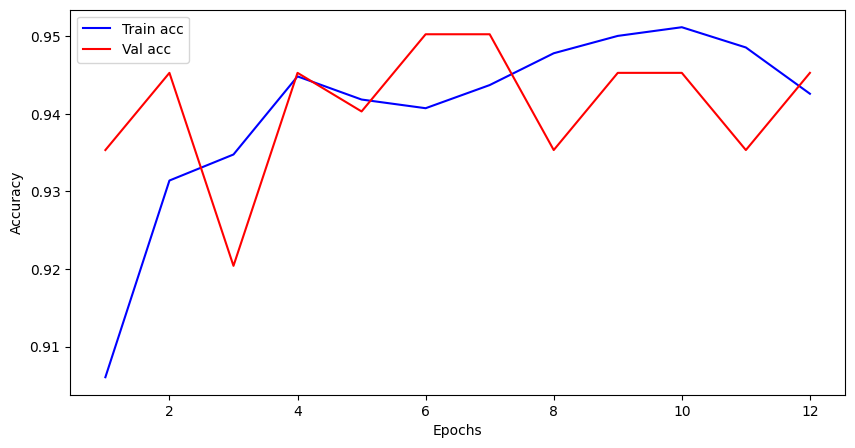

In [72]:
num_epoch2 = [x+1 for x in range(len(tr_losses))]

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
sns.lineplot(x=num_epoch2, y=tr_losses, label = "Train Loss", color = "blue")
sns.lineplot(x=num_epoch2, y=val_losses, label = "Val Loss", color = "red")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.lineplot(x=num_epoch2, y=tr_accs, label = "Train acc", color = "blue")
sns.lineplot(x=num_epoch2, y=val_accs, label = "Val acc", color = "red")
plt.show()

### Тест и анализ

In [73]:
model = timm.create_model("cspresnext50", pretrained = False, num_classes = len(classes))

model.load_state_dict(torch.load('saved_models/fog_best_model.pth'))
model.to(device)
model.eval()

CspNet(
  (stem): Sequential(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): CrossStage(
      (conv_down): Identity()
      (conv_exp): ConvNormAct(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (blocks): Sequential(
        (0): BottleneckBlock(
          (conv1): ConvNormAct(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=1e-5, betas=(0.9, 0.999))

In [76]:
class SaveFeatures():
    
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()



def getCAM(conv_fs, linear_weights, class_idx):
    bs, chs,h, w, = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    return (cam - np.min(cam)) / np.max(cam) 

30it [00:02, 11.96it/s]


acc ->  0.9617021276595744
loss ->  0.12122610894342263


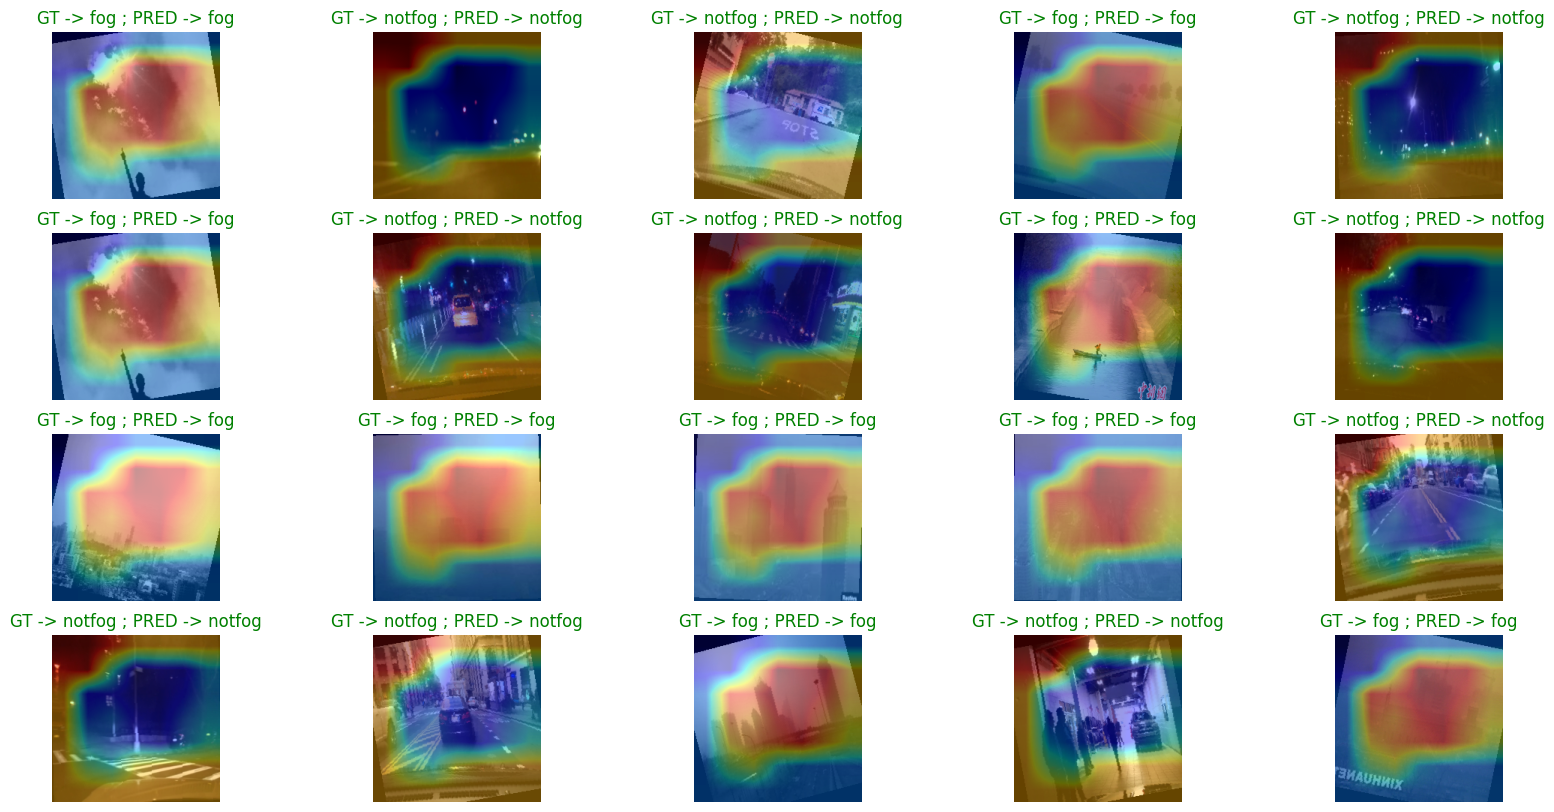

In [78]:
import cv2


def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight = np.squeeze(fc_params[0].cpu().data.numpy())

    activated_features = SaveFeatures(final_conv)
    preds, images, labels = [], [], []
    
    test_epoch_loss, test_epoch_acc = 0, 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_dl)):
            ims = batch[0].to(device)
            gts = batch[1].to(device)
            pred = model(ims)
            loss = loss_fn(pred, gts)
            
            pred_cls = torch.argmax(pred.data, dim = 1)
            test_epoch_loss += loss.item()
            test_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
    
            #preds.append(pred_cls.item())
            #images.append(ims)
            #labels.append(gts.item())
            preds.extend(pred_cls.cpu().numpy())
            images.extend(ims)
            labels.extend(gts)
    
        test_loss_to_track = test_epoch_loss / len(test_dl)
        test_acc_to_track = test_epoch_acc / len(test_dl.dataset)

    print("acc -> ", test_acc_to_track)
    print("loss -> ", test_loss_to_track)

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        image = images[indeks].squeeze()
        pred_idx = labels[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(image), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(labels[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(labels[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

final_conv, fc_params = model.stages[-1].conv_transition, list(model.head.parameters())
inference(model = model.to(device), device = device, test_dl = test_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv
= final_conv, fc_params = fc_params)
#model.layer4[2].conv3